## << 문제 정의 | Problem Definition >>

주어진 **산업용 펌프 센서 데이터**를 사용하여 다음 두 가지 태스크를 수행합니다:

1. **이상 탐지 (Anomaly Detection)**: 펌프의 정상/이상 상태를 분류하는 이진 분류 문제
2. **건강 점수 예측 (Health Score Prediction)**: 펌프의 건강 상태를 나타내는 연속 변수 예측

---

### 데이터 설명 | Data Description

**1. train.csv**
- 학습에 사용되는 데이터로 2024년 1월 1일 0시부터의 펌프 센서 데이터가 15분 간격으로 기록되어 있습니다.
- **컬럼 구성**:
  - `timestamp`: 측정 시간
  - `temperature`: 펌프 온도 (°C)
  - `pressure`: 압력 (bar)
  - `vibration`: 진동 (mm/s)
  - `flow_rate`: 유량 (L/min)
  - `rpm`: 분당 회전수
  - `power`: 전력 소비 (kW)
  - `anomaly`: 이상 여부 (0: 정상, 1: 이상) - **분류 타겟**
  - `health_score`: 장비 건강 점수 (0-100) - **회귀 타겟**

**2. test.csv**
- 예측에 사용되는 데이터로 2024년 6월 1일 0시부터의 센서 데이터가 포함되어 있습니다.
- `anomaly`와 `health_score` 컬럼이 제외되어 있습니다.

**3. sample_submission.csv**
- 예측 결과를 기록하는 파일입니다.
- `anomaly`: 이상 여부 예측값 (0 또는 1)
- `health_score`: 건강 점수 예측값 (0-100)

---

### 평가 지표 | Evaluation Metrics

1. **이상 탐지**: F1-Score (데이터 불균형으로 인해 Accuracy 대신 F1 사용)
2. **건강 점수 예측**: RMSE (Root Mean Squared Error)

---

### 주요 과제 | Key Challenges

- **데이터 불균형 처리**: 이상 데이터가 전체의 약 5%로 불균형함
- **결측치 처리**: 일부 센서 데이터에 결측치 존재
- **특성 공학**: 시계열 데이터에서 유의미한 특성 추출
- **임계값 최적화**: 분류 모델의 최적 임계값 탐색

In [3]:
# 필요한 패키지 설치 | Install required packages
!pip install imbalanced-learn xgboost lightgbm optuna


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
# 라이브러리 임포트 | Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# 머신러닝 라이브러리 | Machine Learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_recall_curve, roc_auc_score, roc_curve,
    mean_squared_error, r2_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

# 데이터 불균형 처리 | Handling imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# 딥러닝 라이브러리 | Deep Learning libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Optuna for hyperparameter tuning
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 재현성을 위한 시드 설정 | Set seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 디바이스 설정 | Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 데이터 경로 설정 | Data path configuration
DATA_PATH = 'dataset/'

Using device: cuda


In [5]:
# Google Colab 환경 설정 (필요시) | Google Colab setup (if needed)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = '/content/drive/MyDrive/your_path/dataset/'
    print("Running in Google Colab")
except ImportError:
    DATA_PATH = 'dataset/'
    print("Running in local environment")

print(f"Data path: {DATA_PATH}")

Running in local environment
Data path: dataset/


---
### Q1. 데이터 로드 및 기본 정보 확인 | Load Data and Check Basic Info

train.csv와 test.csv를 불러오고, 각 데이터의 shape과 기본 통계량을 출력하세요.

In [6]:
# A1. 데이터 로드 및 기본 정보 확인
# A1. Load data and check basic info

# 데이터 로드 | Load data
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')

# 데이터 크기 확인 | Check data shape
print("=" * 60)
print("데이터 크기 | Data Shape")
print("=" * 60)
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# 학습 데이터 기본 정보 | Train data basic info
print("\n" + "=" * 60)
print("학습 데이터 정보 | Train Data Info")
print("=" * 60)
print(train.info())

# 학습 데이터 통계량 | Train data statistics
print("\n" + "=" * 60)
print("학습 데이터 통계량 | Train Data Statistics")
print("=" * 60)
print(train.describe())

# 테스트 데이터 통계량 | Test data statistics
print("\n" + "=" * 60)
print("테스트 데이터 통계량 | Test Data Statistics")
print("=" * 60)
print(test.describe())

# 첫 5개 행 확인 | Check first 5 rows
print("\n" + "=" * 60)
print("학습 데이터 첫 5개 행 | Train Data First 5 Rows")
print("=" * 60)
print(train.head())

데이터 크기 | Data Shape
Train shape: (50000, 9)
Test shape: (10000, 7)

학습 데이터 정보 | Train Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     50000 non-null  object 
 1   temperature   50000 non-null  float64
 2   pressure      49000 non-null  float64
 3   vibration     49000 non-null  float64
 4   flow_rate     49000 non-null  float64
 5   rpm           50000 non-null  int64  
 6   power         50000 non-null  float64
 7   anomaly       50000 non-null  int64  
 8   health_score  50000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 3.4+ MB
None

학습 데이터 통계량 | Train Data Statistics
        temperature      pressure     vibration     flow_rate           rpm  \
count  50000.000000  49000.000000  49000.000000  49000.000000  50000.000000   
mean      65.373157      3.476297      2.594416    149.239208 

---
### Q2. 결측치 확인 및 처리 | Check and Handle Missing Values

train, test 데이터의 결측치를 확인하고, 적절한 방법으로 결측치를 처리하세요.
- 힌트: 센서 데이터의 특성상 선형 보간(linear interpolation)이나 전후 값으로 채우기(ffill/bfill)를 고려해보세요.

In [7]:
# A2. 결측치 확인 및 처리
# A2. Check and handle missing values

# 결측치 확인 | Check missing values
print("=" * 60)
print("결측치 현황 (처리 전) | Missing Values (Before)")
print("=" * 60)
print("\n[Train 결측치 | Train Missing Values]")
print(train.isnull().sum())
print(f"\n총 결측치 수: {train.isnull().sum().sum()}")

print("\n[Test 결측치 | Test Missing Values]")
print(test.isnull().sum())
print(f"\n총 결측치 수: {test.isnull().sum().sum()}")

# 센서 데이터 컬럼 정의 | Define sensor data columns
sensor_cols = ['temperature', 'pressure', 'vibration', 'flow_rate', 'rpm', 'power']

# 결측치 처리 함수 정의 | Define missing value handling function
def handle_missing_values(df: pd.DataFrame, sensor_columns: list) -> pd.DataFrame:
    """
    센서 데이터의 결측치를 처리합니다.
    Handle missing values in sensor data.
    
    Args:
        df: 입력 데이터프레임 | Input DataFrame
        sensor_columns: 센서 컬럼 리스트 | List of sensor columns
    
    Returns:
        결측치가 처리된 데이터프레임 | DataFrame with handled missing values
    """
    df_copy = df.copy()
    
    # 1단계: 선형 보간 적용 | Step 1: Apply linear interpolation
    # 센서 데이터는 시계열 특성상 선형 보간이 적합
    # Linear interpolation is suitable for time-series sensor data
    for col in sensor_columns:
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].interpolate(method='linear')
    
    # 2단계: 남은 결측치 처리 (첫 행/마지막 행) | Step 2: Handle remaining NaN (first/last rows)
    # ffill: 앞의 값으로 채우기 | Forward fill
    # bfill: 뒤의 값으로 채우기 | Backward fill
    df_copy = df_copy.ffill()
    df_copy = df_copy.bfill()
    
    return df_copy

# 결측치 처리 적용 | Apply missing value handling
train = handle_missing_values(train, sensor_cols)
test = handle_missing_values(test, sensor_cols)

# 처리 후 결측치 확인 | Check missing values after handling
print("\n" + "=" * 60)
print("결측치 현황 (처리 후) | Missing Values (After)")
print("=" * 60)
print("\n[Train 결측치 | Train Missing Values]")
print(train.isnull().sum())
print(f"\n총 결측치 수: {train.isnull().sum().sum()}")

print("\n[Test 결측치 | Test Missing Values]")
print(test.isnull().sum())
print(f"\n총 결측치 수: {test.isnull().sum().sum()}")

print("\n✅ 결측치 처리 완료! | Missing value handling completed!")

결측치 현황 (처리 전) | Missing Values (Before)

[Train 결측치 | Train Missing Values]
timestamp          0
temperature        0
pressure        1000
vibration       1000
flow_rate       1000
rpm                0
power              0
anomaly            0
health_score       0
dtype: int64

총 결측치 수: 3000

[Test 결측치 | Test Missing Values]
timestamp        0
temperature      0
pressure       100
vibration      100
flow_rate        0
rpm              0
power            0
dtype: int64

총 결측치 수: 200

결측치 현황 (처리 후) | Missing Values (After)

[Train 결측치 | Train Missing Values]
timestamp       0
temperature     0
pressure        0
vibration       0
flow_rate       0
rpm             0
power           0
anomaly         0
health_score    0
dtype: int64

총 결측치 수: 0

[Test 결측치 | Test Missing Values]
timestamp      0
temperature    0
pressure       0
vibration      0
flow_rate      0
rpm            0
power          0
dtype: int64

총 결측치 수: 0

✅ 결측치 처리 완료! | Missing value handling completed!


---
### Q3. 클래스 불균형 분석 | Analyze Class Imbalance

train 데이터의 `anomaly` 컬럼에서 클래스 분포를 확인하고, 불균형 비율을 계산하세요.
- 정상(0)과 이상(1)의 개수 및 비율을 출력하세요.
- 시각화를 통해 클래스 불균형을 확인하세요.

클래스 분포 | Class Distribution

정상 (Normal, 0): 47,500개 (95.00%)
이상 (Anomaly, 1): 2,500개 (5.00%)

불균형 비율 (Imbalance Ratio): 19.00:1
  → 정상 데이터가 이상 데이터보다 약 19.0배 많음
  → Normal data is approximately 19.0x more than anomaly data


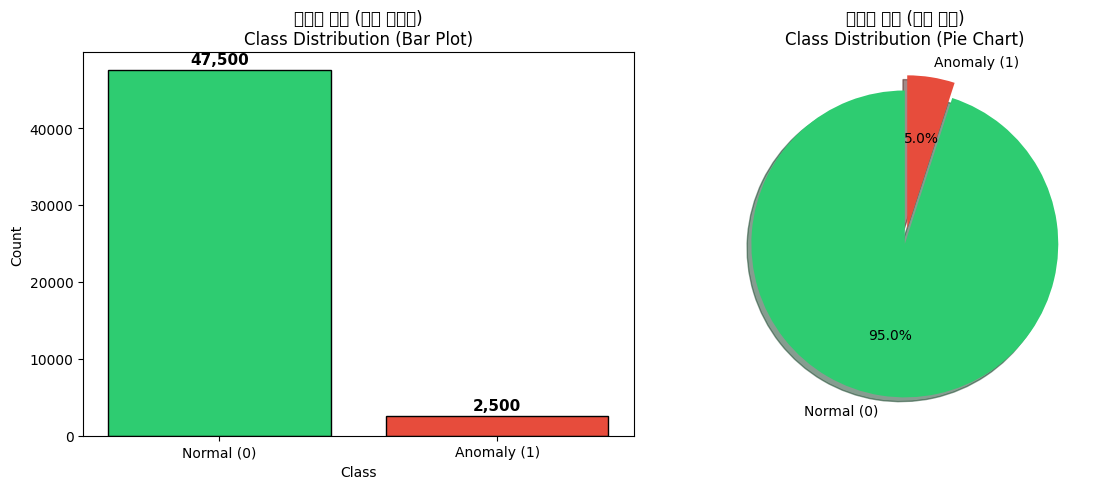


📊 분석 요약 | Analysis Summary
• 데이터가 심각하게 불균형함 (약 5% vs 95%)
• Data is severely imbalanced (approximately 5% vs 95%)
• 이 불균형 문제를 해결하기 위해 다음 방법들을 사용할 예정:
• To address this imbalance, we will use the following methods:
  1. Class weights (클래스 가중치)
  2. SMOTE oversampling (SMOTE 오버샘플링)
  3. Threshold optimization (임계값 최적화)


In [8]:
# A3. 클래스 불균형 분석
# A3. Analyze class imbalance

# 클래스별 개수 계산 | Calculate class counts
class_counts = train['anomaly'].value_counts().sort_index()  # 인덱스로 정렬 | Sort by index
class_ratio = train['anomaly'].value_counts(normalize=True).sort_index() * 100

# 클래스 분포 출력 | Print class distribution
print("=" * 60)
print("클래스 분포 | Class Distribution")
print("=" * 60)
normal_count = class_counts.get(0, 0)
anomaly_count = class_counts.get(1, 0)
normal_ratio = class_ratio.get(0, 0)
anomaly_ratio = class_ratio.get(1, 0)

print(f"\n정상 (Normal, 0): {normal_count:,}개 ({normal_ratio:.2f}%)")
print(f"이상 (Anomaly, 1): {anomaly_count:,}개 ({anomaly_ratio:.2f}%)")

# 불균형 비율 계산 | Calculate imbalance ratio
# 불균형 비율 = 다수 클래스 / 소수 클래스
# Imbalance ratio = majority class / minority class
imbalance_ratio = normal_count / anomaly_count if anomaly_count > 0 else float('inf')
print(f"\n불균형 비율 (Imbalance Ratio): {imbalance_ratio:.2f}:1")
print(f"  → 정상 데이터가 이상 데이터보다 약 {imbalance_ratio:.1f}배 많음")
print(f"  → Normal data is approximately {imbalance_ratio:.1f}x more than anomaly data")

# 시각화 | Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 막대 그래프 | Bar plot
colors = ['#2ecc71', '#e74c3c']  # 녹색(정상), 빨간색(이상)
plot_counts = [normal_count, anomaly_count]
bars = axes[0].bar(['Normal (0)', 'Anomaly (1)'], plot_counts, color=colors, edgecolor='black')
axes[0].set_title('클래스 분포 (막대 그래프)\nClass Distribution (Bar Plot)', fontsize=12)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
# 막대 위에 개수 표시 | Display count on bars
for bar, count in zip(bars, plot_counts):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 500,
                 f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 파이 차트 | Pie chart
axes[1].pie(plot_counts, labels=['Normal (0)', 'Anomaly (1)'],
            autopct='%1.1f%%', colors=colors, explode=(0, 0.1),
            shadow=True, startangle=90)
axes[1].set_title('클래스 분포 (파이 차트)\nClass Distribution (Pie Chart)', fontsize=12)

plt.tight_layout()
plt.show()

# 요약 | Summary
print("\n" + "=" * 60)
print("📊 분석 요약 | Analysis Summary")
print("=" * 60)
print("• 데이터가 심각하게 불균형함 (약 5% vs 95%)")
print("• Data is severely imbalanced (approximately 5% vs 95%)")
print("• 이 불균형 문제를 해결하기 위해 다음 방법들을 사용할 예정:")
print("• To address this imbalance, we will use the following methods:")
print("  1. Class weights (클래스 가중치)")
print("  2. SMOTE oversampling (SMOTE 오버샘플링)")
print("  3. Threshold optimization (임계값 최적화)")

---
### Q4. 특성 공학 - 시간 기반 특성 생성 | Feature Engineering - Time-based Features

`timestamp` 컬럼을 사용하여 다음 특성들을 생성하세요:
- `hour`: 시간 (0-23)
- `day_of_week`: 요일 (0-6)
- `hour_sin`, `hour_cos`: 시간의 순환 변환 (24시간 주기)
- `day_sin`, `day_cos`: 요일의 순환 변환 (7일 주기)

생성된 시간 기반 특성 | Created Time-based Features
            timestamp  hour  day_of_week  day_of_month  month  hour_sin  \
0 2024-01-01 00:00:00     0            0             1      1  0.000000   
1 2024-01-01 00:15:00     0            0             1      1  0.000000   
2 2024-01-01 00:30:00     0            0             1      1  0.000000   
3 2024-01-01 00:45:00     0            0             1      1  0.000000   
4 2024-01-01 01:00:00     1            0             1      1  0.258819   
5 2024-01-01 01:15:00     1            0             1      1  0.258819   
6 2024-01-01 01:30:00     1            0             1      1  0.258819   
7 2024-01-01 01:45:00     1            0             1      1  0.258819   
8 2024-01-01 02:00:00     2            0             1      1  0.500000   
9 2024-01-01 02:15:00     2            0             1      1  0.500000   

   hour_cos  day_sin  day_cos  
0  1.000000      0.0      1.0  
1  1.000000      0.0      1.0  
2  1.000000      0.0      1.0  
3  

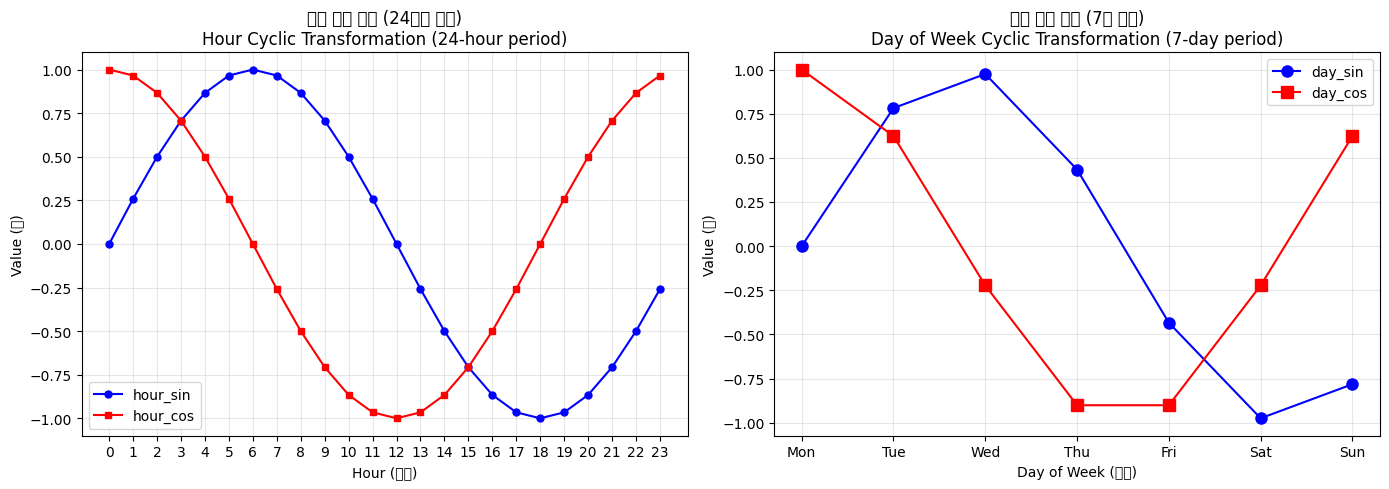


✅ 시간 기반 특성 생성 완료! | Time-based feature creation completed!
Train 컬럼 수: 17, Test 컬럼 수: 15


In [9]:
# A4. 시간 기반 특성 생성
# A4. Create time-based features

def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    timestamp 컬럼으로부터 시간 기반 특성을 생성합니다.
    Create time-based features from timestamp column.
    
    Args:
        df: timestamp 컬럼이 있는 데이터프레임 | DataFrame with timestamp column
    
    Returns:
        시간 기반 특성이 추가된 데이터프레임 | DataFrame with time-based features added
    """
    df_copy = df.copy()
    
    # timestamp를 datetime으로 변환 | Convert timestamp to datetime
    df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])
    
    # 기본 시간 특성 추출 | Extract basic time features
    df_copy['hour'] = df_copy['timestamp'].dt.hour           # 시간 (0-23) | Hour (0-23)
    df_copy['day_of_week'] = df_copy['timestamp'].dt.dayofweek  # 요일 (0-6) | Day of week (0-6)
    df_copy['day_of_month'] = df_copy['timestamp'].dt.day       # 일 (1-31) | Day of month (1-31)
    df_copy['month'] = df_copy['timestamp'].dt.month            # 월 (1-12) | Month (1-12)
    
    # 순환 변환 (Cyclic Transformation) | Cyclic Transformation
    # 시간과 요일은 순환적 특성을 가짐 (23시 → 0시, 토요일 → 일요일)
    # Hour and day_of_week have cyclic nature (23h → 0h, Saturday → Sunday)
    # 공식 | Formula: sin(2π * value / period), cos(2π * value / period)
    
    # 시간 순환 변환 (24시간 주기) | Hour cyclic transformation (24-hour period)
    df_copy['hour_sin'] = np.sin(2 * np.pi * df_copy['hour'] / 24)
    df_copy['hour_cos'] = np.cos(2 * np.pi * df_copy['hour'] / 24)
    
    # 요일 순환 변환 (7일 주기) | Day of week cyclic transformation (7-day period)
    df_copy['day_sin'] = np.sin(2 * np.pi * df_copy['day_of_week'] / 7)
    df_copy['day_cos'] = np.cos(2 * np.pi * df_copy['day_of_week'] / 7)
    
    return df_copy

# 시간 기반 특성 적용 | Apply time-based features
train = create_time_features(train)
test = create_time_features(test)

# 생성된 특성 확인 | Check created features
print("=" * 60)
print("생성된 시간 기반 특성 | Created Time-based Features")
print("=" * 60)
time_cols = ['timestamp', 'hour', 'day_of_week', 'day_of_month', 'month',
             'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
print(train[time_cols].head(10))

# 순환 변환 시각화 | Visualize cyclic transformation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 시간 순환 특성 (24시간) | Hour cyclic features (24 hours)
hours = np.arange(24)
hour_sin = np.sin(2 * np.pi * hours / 24)
hour_cos = np.cos(2 * np.pi * hours / 24)
axes[0].plot(hours, hour_sin, 'b-o', label='hour_sin', markersize=5)
axes[0].plot(hours, hour_cos, 'r-s', label='hour_cos', markersize=5)
axes[0].set_xlabel('Hour (시간)')
axes[0].set_ylabel('Value (값)')
axes[0].set_title('시간 순환 변환 (24시간 주기)\nHour Cyclic Transformation (24-hour period)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(hours)

# 요일 순환 특성 (7일) | Day of week cyclic features (7 days)
days = np.arange(7)
day_sin = np.sin(2 * np.pi * days / 7)
day_cos = np.cos(2 * np.pi * days / 7)
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].plot(days, day_sin, 'b-o', label='day_sin', markersize=8)
axes[1].plot(days, day_cos, 'r-s', label='day_cos', markersize=8)
axes[1].set_xlabel('Day of Week (요일)')
axes[1].set_ylabel('Value (값)')
axes[1].set_title('요일 순환 변환 (7일 주기)\nDay of Week Cyclic Transformation (7-day period)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(days)
axes[1].set_xticklabels(day_names)

plt.tight_layout()
plt.show()

print("\n✅ 시간 기반 특성 생성 완료! | Time-based feature creation completed!")
print(f"Train 컬럼 수: {len(train.columns)}, Test 컬럼 수: {len(test.columns)}")

---
### Q5. 특성 공학 - 롤링 통계량 | Feature Engineering - Rolling Statistics

센서 데이터의 시계열 특성을 반영하기 위해 롤링 통계량을 계산하세요:
- `temperature`, `vibration`, `pressure` 컬럼에 대해
- 윈도우 크기 4 (1시간)에 대한 이동 평균(rolling mean)과 이동 표준편차(rolling std) 계산
- 롤링으로 인해 생성된 NaN 값은 적절히 처리하세요.

In [10]:
# A5. 롤링 통계량 계산
# A5. Calculate rolling statistics

def create_rolling_features(df: pd.DataFrame, columns: list, window: int = 4) -> pd.DataFrame:
    """
    지정된 컬럼에 대해 롤링 통계량을 계산합니다.
    Calculate rolling statistics for specified columns.
    
    Args:
        df: 입력 데이터프레임 | Input DataFrame
        columns: 롤링 통계량을 계산할 컬럼 리스트 | List of columns for rolling statistics
        window: 윈도우 크기 (기본값: 4 = 1시간) | Window size (default: 4 = 1 hour)
    
    Returns:
        롤링 통계량이 추가된 데이터프레임 | DataFrame with rolling statistics added
    """
    df_copy = df.copy()
    
    for col in columns:
        # 이동 평균 | Rolling mean
        df_copy[f'{col}_rolling_mean'] = df_copy[col].rolling(
            window=window, min_periods=1
        ).mean()
        
        # 이동 표준편차 | Rolling standard deviation
        # min_periods=2로 설정하여 최소 2개 값으로 std 계산 가능
        # Set min_periods=2 so std can be calculated with at least 2 values
        df_copy[f'{col}_rolling_std'] = df_copy[col].rolling(
            window=window, min_periods=2
        ).std()
        
        # 이동 평균과의 편차 (현재값 - 이동평균) | Deviation from rolling mean
        df_copy[f'{col}_rolling_dev'] = df_copy[col] - df_copy[f'{col}_rolling_mean']
    
    return df_copy

# 롤링 통계량을 적용할 센서 컬럼 | Sensor columns for rolling statistics
rolling_cols = ['temperature', 'vibration', 'pressure']

# 윈도우 크기 설정 | Set window size
# 15분 간격 데이터이므로 window=4는 1시간을 의미
# With 15-minute intervals, window=4 means 1 hour
WINDOW_SIZE = 4

# 롤링 통계량 적용 | Apply rolling statistics
train = create_rolling_features(train, rolling_cols, window=WINDOW_SIZE)
test = create_rolling_features(test, rolling_cols, window=WINDOW_SIZE)

# 롤링으로 인한 NaN 처리 | Handle NaN from rolling
# rolling_std의 첫 번째 행은 NaN이 됨 (단일 값으로 std 계산 불가)
# First row of rolling_std will be NaN (can't calculate std with single value)
# bfill: 뒤의 값으로 채우기 (backward fill) | Fill with next valid value
# ffill: 앞의 값으로 채우기 (forward fill) | Fill with previous valid value
train = train.bfill().ffill()
test = test.bfill().ffill()

# 여전히 NaN이 있다면 0으로 채우기 | Fill any remaining NaN with 0
train = train.fillna(0)
test = test.fillna(0)

# 생성된 롤링 특성 확인 | Check created rolling features
print("=" * 60)
print("생성된 롤링 특성 | Created Rolling Features")
print("=" * 60)

rolling_feature_cols = []
for col in rolling_cols:
    rolling_feature_cols.extend([
        f'{col}_rolling_mean',
        f'{col}_rolling_std',
        f'{col}_rolling_dev'
    ])

print("\n[새로 생성된 롤링 특성 컬럼 | New Rolling Feature Columns]")
for i, col in enumerate(rolling_feature_cols, 1):
    print(f"  {i}. {col}")

print(f"\n[Train 롤링 특성 샘플 | Train Rolling Features Sample]")
print(train[['temperature'] + [c for c in rolling_feature_cols if 'temperature' in c]].head(10))

# 결측치 확인 | Check missing values
print("\n" + "=" * 60)
print("롤링 특성 결측치 확인 | Rolling Features Missing Value Check")
print("=" * 60)
print(f"Train 결측치: {train[rolling_feature_cols].isnull().sum().sum()}")
print(f"Test 결측치: {test[rolling_feature_cols].isnull().sum().sum()}")

# 최종 데이터 크기 확인 | Check final data shape
print("\n" + "=" * 60)
print("최종 데이터 크기 | Final Data Shape")
print("=" * 60)
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")
print(f"\n✅ 롤링 통계량 생성 완료! | Rolling statistics creation completed!")

생성된 롤링 특성 | Created Rolling Features

[새로 생성된 롤링 특성 컬럼 | New Rolling Feature Columns]
  1. temperature_rolling_mean
  2. temperature_rolling_std
  3. temperature_rolling_dev
  4. vibration_rolling_mean
  5. vibration_rolling_std
  6. vibration_rolling_dev
  7. pressure_rolling_mean
  8. pressure_rolling_std
  9. pressure_rolling_dev

[Train 롤링 특성 샘플 | Train Rolling Features Sample]
   temperature  temperature_rolling_mean  temperature_rolling_std  \
0        67.48                 67.480000                 2.241528   
1        64.31                 65.895000                 2.241528   
2        68.24                 66.676667                 2.084522   
3        72.62                 68.162500                 3.424562   
4        63.96                 67.282500                 4.053002   
5        63.96                 67.195000                 4.141381   
6        73.03                 68.392500                 5.120946   
7        68.97                 67.480000                 4.3895

---
### Q6. 데이터 분할 | Train/Validation Split

학습 데이터를 train/validation으로 8:2 비율로 분할하세요.
- **중요**: 클래스 불균형 데이터이므로 **Stratified Split**을 사용해야 합니다.
- 특성 행렬 X와 분류 타겟 y_cls, 회귀 타겟 y_reg를 생성하세요.
- `timestamp` 컬럼은 제거하세요.

In [11]:
# A6. 데이터 분할
# A6. Train/Validation split

# 특성 컬럼 선택 (timestamp와 타겟 변수 제외) | Select feature columns (exclude timestamp and targets)
feature_cols = [col for col in train.columns if col not in ['timestamp', 'anomaly', 'health_score']]

print("=" * 60)
print("특성 컬럼 목록 | Feature Columns")
print("=" * 60)
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")
print(f"\n총 특성 개수: {len(feature_cols)}개")

# 특성 행렬 X 생성 | Create feature matrix X
X = train[feature_cols]

# 분류 타겟 y_cls 생성 | Create classification target y_cls
y_cls = train['anomaly']

# 회귀 타겟 y_reg 생성 | Create regression target y_reg
y_reg = train['health_score']

# Stratified Split으로 데이터 분할 (80:20) | Split data with Stratified Split (80:20)
# 클래스 불균형 데이터이므로 stratify 옵션 사용 필수
# Use stratify option for imbalanced data
X_train, X_val, y_train_cls, y_val_cls = train_test_split(
    X, y_cls,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_cls  # 클래스 비율 유지 | Maintain class ratio
)

# 분할 결과 확인 | Check split results
print("\n" + "=" * 60)
print("데이터 분할 결과 | Data Split Results")
print("=" * 60)
print(f"\n[데이터 크기 | Data Shape]")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train_cls: {y_train_cls.shape}")
print(f"y_val_cls: {y_val_cls.shape}")

# 클래스 비율 확인 (Stratified Split 검증) | Check class ratio (Stratified Split verification)
print(f"\n[클래스 비율 검증 | Class Ratio Verification]")

# 안전한 인덱싱 사용 | Use safe indexing
train_counts = y_train_cls.value_counts().sort_index()
val_counts = y_val_cls.value_counts().sort_index()

train_normal = train_counts.get(0, 0)
train_anomaly = train_counts.get(1, 0)
val_normal = val_counts.get(0, 0)
val_anomaly = val_counts.get(1, 0)

print(f"\n원본 데이터 | Original Data:")
print(f"  - 정상(0): {(y_cls == 0).sum():,}개 ({(y_cls == 0).mean() * 100:.2f}%)")
print(f"  - 이상(1): {(y_cls == 1).sum():,}개 ({(y_cls == 1).mean() * 100:.2f}%)")

print(f"\n학습 데이터 | Train Data:")
print(f"  - 정상(0): {train_normal:,}개 ({train_normal / len(y_train_cls) * 100:.2f}%)")
print(f"  - 이상(1): {train_anomaly:,}개 ({train_anomaly / len(y_train_cls) * 100:.2f}%)")

print(f"\n검증 데이터 | Validation Data:")
print(f"  - 정상(0): {val_normal:,}개 ({val_normal / len(y_val_cls) * 100:.2f}%)")
print(f"  - 이상(1): {val_anomaly:,}개 ({val_anomaly / len(y_val_cls) * 100:.2f}%)")

# 회귀 타겟도 동일한 인덱스로 분할 | Split regression target with same indices
y_train_reg = train.loc[X_train.index, 'health_score']
y_val_reg = train.loc[X_val.index, 'health_score']

print(f"\n[회귀 타겟 | Regression Target]")
print(f"y_train_reg: {y_train_reg.shape}, y_val_reg: {y_val_reg.shape}")
print(f"y_train_reg 범위: {y_train_reg.min():.2f} ~ {y_train_reg.max():.2f}")
print(f"y_val_reg 범위: {y_val_reg.min():.2f} ~ {y_val_reg.max():.2f}")

print("\n✅ 데이터 분할 완료! | Data split completed!")
print("✅ Stratified Split으로 클래스 비율이 유지되었습니다.")
print("✅ Class ratio is maintained with Stratified Split.")

특성 컬럼 목록 | Feature Columns
   1. temperature
   2. pressure
   3. vibration
   4. flow_rate
   5. rpm
   6. power
   7. hour
   8. day_of_week
   9. day_of_month
  10. month
  11. hour_sin
  12. hour_cos
  13. day_sin
  14. day_cos
  15. temperature_rolling_mean
  16. temperature_rolling_std
  17. temperature_rolling_dev
  18. vibration_rolling_mean
  19. vibration_rolling_std
  20. vibration_rolling_dev
  21. pressure_rolling_mean
  22. pressure_rolling_std
  23. pressure_rolling_dev

총 특성 개수: 23개

데이터 분할 결과 | Data Split Results

[데이터 크기 | Data Shape]
X_train: (40000, 23)
X_val: (10000, 23)
y_train_cls: (40000,)
y_val_cls: (10000,)

[클래스 비율 검증 | Class Ratio Verification]

원본 데이터 | Original Data:
  - 정상(0): 47,500개 (95.00%)
  - 이상(1): 2,500개 (5.00%)

학습 데이터 | Train Data:
  - 정상(0): 38,000개 (95.00%)
  - 이상(1): 2,000개 (5.00%)

검증 데이터 | Validation Data:
  - 정상(0): 9,500개 (95.00%)
  - 이상(1): 500개 (5.00%)

[회귀 타겟 | Regression Target]
y_train_reg: (40000,), y_val_reg: (10000,)
y_train_reg 범위

---
### Q7. 기준 모델 - Class Weight 적용 | Baseline Model with Class Weights

데이터 불균형을 처리하는 첫 번째 방법으로 **class_weight='balanced'** 옵션을 사용하여 XGBoost 모델을 학습하세요.
- 검증 데이터에 대한 F1-Score, Precision, Recall을 출력하세요.
- Confusion Matrix를 시각화하세요.

클래스 가중치 계산 | Class Weight Calculation
정상(0) 개수: 38,000
이상(1) 개수: 2,000
scale_pos_weight: 19.00

모델 학습 중... | Training model...
✅ 모델 학습 완료! | Model training completed!

기준 모델 성능 평가 | Baseline Model Performance

F1-Score: 0.9279
AUC-ROC: 0.9950

[Classification Report]
              precision    recall  f1-score   support

  Normal (0)       1.00      0.99      1.00      9500
 Anomaly (1)       0.90      0.95      0.93       500

    accuracy                           0.99     10000
   macro avg       0.95      0.97      0.96     10000
weighted avg       0.99      0.99      0.99     10000



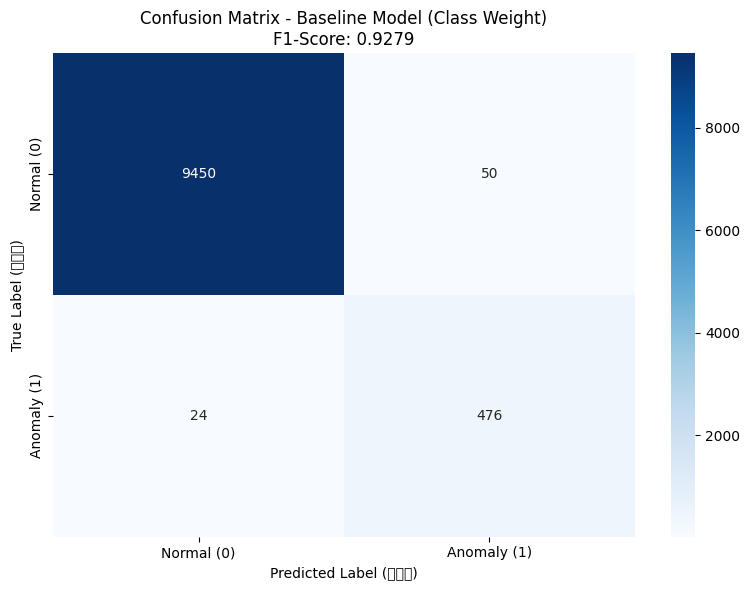


[Confusion Matrix 상세 | Confusion Matrix Details]
True Negative (TN): 9,450 - 정상을 정상으로 예측
False Positive (FP): 50 - 정상을 이상으로 예측 (오탐)
False Negative (FN): 24 - 이상을 정상으로 예측 (미탐)
True Positive (TP): 476 - 이상을 이상으로 예측

Precision: 0.9049
Recall: 0.9520


In [12]:
# A7. Class Weight를 적용한 기준 모델
# A7. Baseline model with class weights

# scale_pos_weight 계산 | Calculate scale_pos_weight
# scale_pos_weight = 음성 클래스 수 / 양성 클래스 수
# scale_pos_weight = count(negative) / count(positive)
neg_count = (y_train_cls == 0).sum()
pos_count = (y_train_cls == 1).sum()
scale_pos_weight = neg_count / pos_count

print("=" * 60)
print("클래스 가중치 계산 | Class Weight Calculation")
print("=" * 60)
print(f"정상(0) 개수: {neg_count:,}")
print(f"이상(1) 개수: {pos_count:,}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# XGBoost 모델 정의 (클래스 가중치 적용) | Define XGBoost model (with class weights)
baseline_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  # 클래스 불균형 처리 | Handle class imbalance
    random_state=RANDOM_SEED,
    eval_metric='logloss',
    use_label_encoder=False
)

# 모델 학습 | Train model
print("\n모델 학습 중... | Training model...")
baseline_model.fit(X_train, y_train_cls)
print("✅ 모델 학습 완료! | Model training completed!")

# 예측 | Prediction
y_pred_baseline = baseline_model.predict(X_val)
y_pred_proba_baseline = baseline_model.predict_proba(X_val)[:, 1]

# 성능 평가 | Performance evaluation
print("\n" + "=" * 60)
print("기준 모델 성능 평가 | Baseline Model Performance")
print("=" * 60)

f1_baseline = f1_score(y_val_cls, y_pred_baseline)
auc_baseline = roc_auc_score(y_val_cls, y_pred_proba_baseline)

print(f"\nF1-Score: {f1_baseline:.4f}")
print(f"AUC-ROC: {auc_baseline:.4f}")

print("\n[Classification Report]")
print(classification_report(y_val_cls, y_pred_baseline, target_names=['Normal (0)', 'Anomaly (1)']))

# Confusion Matrix 시각화 | Visualize Confusion Matrix
cm = confusion_matrix(y_val_cls, y_pred_baseline)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Normal (0)', 'Anomaly (1)'],
            yticklabels=['Normal (0)', 'Anomaly (1)'])
ax.set_xlabel('Predicted Label (예측값)')
ax.set_ylabel('True Label (실제값)')
ax.set_title(f'Confusion Matrix - Baseline Model (Class Weight)\nF1-Score: {f1_baseline:.4f}')
plt.tight_layout()
plt.show()

# Confusion Matrix 해석 | Interpret Confusion Matrix
tn, fp, fn, tp = cm.ravel()
print("\n[Confusion Matrix 상세 | Confusion Matrix Details]")
print(f"True Negative (TN): {tn:,} - 정상을 정상으로 예측")
print(f"False Positive (FP): {fp:,} - 정상을 이상으로 예측 (오탐)")
print(f"False Negative (FN): {fn:,} - 이상을 정상으로 예측 (미탐)")
print(f"True Positive (TP): {tp:,} - 이상을 이상으로 예측")

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

---
### Q8. SMOTE를 사용한 오버샘플링 | Oversampling with SMOTE

데이터 불균형을 처리하는 두 번째 방법으로 **SMOTE (Synthetic Minority Over-sampling Technique)**를 사용하세요.
- 학습 데이터에만 SMOTE를 적용하세요 (검증 데이터는 원본 유지)
- SMOTE 적용 후 클래스 분포를 확인하세요
- XGBoost 모델을 학습하고 F1-Score를 비교하세요

SMOTE 적용 전 클래스 분포 | Class Distribution Before SMOTE
정상(0): 38,000개
이상(1): 2,000개
비율: 19.00:1

SMOTE 적용 후 클래스 분포 | Class Distribution After SMOTE
정상(0): 38,000개
이상(1): 38,000개
비율: 1.00:1

총 데이터 수: 40,000개 → 76,000개


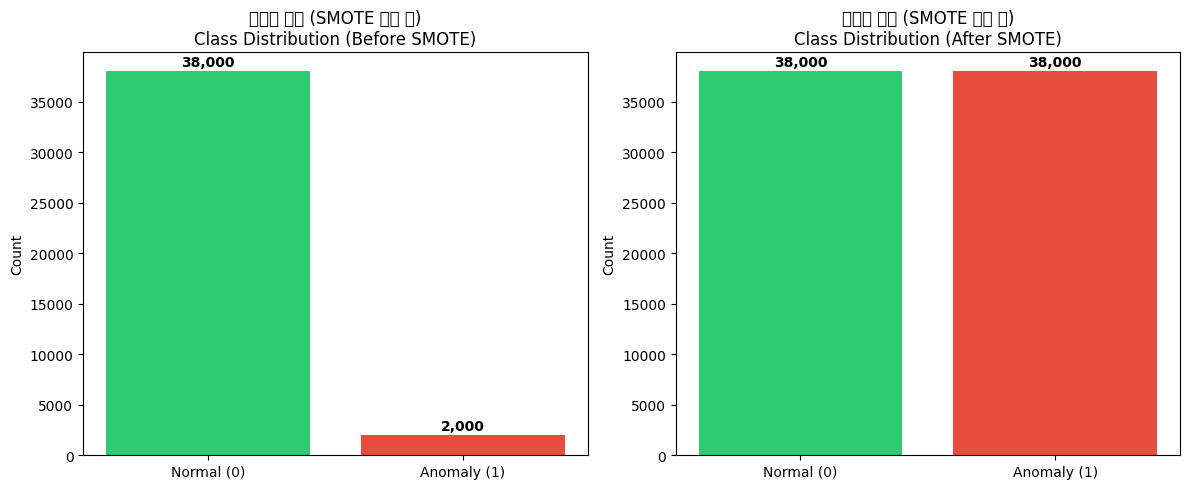


SMOTE 모델 학습 | SMOTE Model Training
모델 학습 중... | Training model...
✅ 모델 학습 완료! | Model training completed!

SMOTE 모델 성능 평가 | SMOTE Model Performance

F1-Score: 0.9427
AUC-ROC: 0.9953

[Classification Report]
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00      9500
 Anomaly (1)       0.95      0.94      0.94       500

    accuracy                           0.99     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.99      0.99      0.99     10000


모델 성능 비교 | Model Performance Comparison
모델 | Model                     F1-Score        AUC-ROC        
------------------------------------------------------------
Baseline (Class Weight)        0.9279          0.9950         
SMOTE                          0.9427          0.9953         
------------------------------------------------------------
✅ SMOTE 모델이 F1-Score에서 더 좋은 성능을 보임
✅ SMOTE model shows better F1-Score


In [13]:
# A8. SMOTE를 사용한 오버샘플링
# A8. Oversampling with SMOTE

# SMOTE 적용 전 클래스 분포 확인 | Check class distribution before SMOTE
print("=" * 60)
print("SMOTE 적용 전 클래스 분포 | Class Distribution Before SMOTE")
print("=" * 60)
print(f"정상(0): {(y_train_cls == 0).sum():,}개")
print(f"이상(1): {(y_train_cls == 1).sum():,}개")
print(f"비율: {(y_train_cls == 0).sum() / (y_train_cls == 1).sum():.2f}:1")

# SMOTE 적용 | Apply SMOTE
# SMOTE: Synthetic Minority Over-sampling Technique
# 소수 클래스의 합성 샘플을 생성하여 클래스 균형을 맞춤
# Creates synthetic samples for minority class to balance classes
smote = SMOTE(random_state=RANDOM_SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_cls)

# SMOTE 적용 후 클래스 분포 확인 | Check class distribution after SMOTE
print("\n" + "=" * 60)
print("SMOTE 적용 후 클래스 분포 | Class Distribution After SMOTE")
print("=" * 60)
print(f"정상(0): {(y_train_smote == 0).sum():,}개")
print(f"이상(1): {(y_train_smote == 1).sum():,}개")
print(f"비율: {(y_train_smote == 0).sum() / (y_train_smote == 1).sum():.2f}:1")
print(f"\n총 데이터 수: {len(X_train):,}개 → {len(X_train_smote):,}개")

# SMOTE 클래스 분포 시각화 | Visualize SMOTE class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
before_counts = [sum(y_train_cls == 0), sum(y_train_cls == 1)]
axes[0].bar(['Normal (0)', 'Anomaly (1)'], before_counts, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('클래스 분포 (SMOTE 적용 전)\nClass Distribution (Before SMOTE)')
axes[0].set_ylabel('Count')
for i, v in enumerate(before_counts):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

# After SMOTE
after_counts = [sum(y_train_smote == 0), sum(y_train_smote == 1)]
axes[1].bar(['Normal (0)', 'Anomaly (1)'], after_counts, color=['#2ecc71', '#e74c3c'])
axes[1].set_title('클래스 분포 (SMOTE 적용 후)\nClass Distribution (After SMOTE)')
axes[1].set_ylabel('Count')
for i, v in enumerate(after_counts):
    axes[1].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# SMOTE 데이터로 XGBoost 모델 학습 | Train XGBoost model with SMOTE data
print("\n" + "=" * 60)
print("SMOTE 모델 학습 | SMOTE Model Training")
print("=" * 60)

smote_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_SEED,
    eval_metric='logloss',
    use_label_encoder=False
)

print("모델 학습 중... | Training model...")
smote_model.fit(X_train_smote, y_train_smote)
print("✅ 모델 학습 완료! | Model training completed!")

# 검증 데이터로 예측 (원본 검증 데이터 사용) | Predict on validation data (original validation data)
y_pred_smote = smote_model.predict(X_val)
y_pred_proba_smote = smote_model.predict_proba(X_val)[:, 1]

# 성능 평가 | Performance evaluation
f1_smote = f1_score(y_val_cls, y_pred_smote)
auc_smote = roc_auc_score(y_val_cls, y_pred_proba_smote)

print("\n" + "=" * 60)
print("SMOTE 모델 성능 평가 | SMOTE Model Performance")
print("=" * 60)
print(f"\nF1-Score: {f1_smote:.4f}")
print(f"AUC-ROC: {auc_smote:.4f}")

print("\n[Classification Report]")
print(classification_report(y_val_cls, y_pred_smote, target_names=['Normal (0)', 'Anomaly (1)']))

# 기준 모델과 비교 | Compare with baseline model
print("\n" + "=" * 60)
print("모델 성능 비교 | Model Performance Comparison")
print("=" * 60)
print(f"{'모델 | Model':<30} {'F1-Score':<15} {'AUC-ROC':<15}")
print("-" * 60)
print(f"{'Baseline (Class Weight)':<30} {f1_baseline:<15.4f} {auc_baseline:<15.4f}")
print(f"{'SMOTE':<30} {f1_smote:<15.4f} {auc_smote:<15.4f}")
print("-" * 60)

# 어떤 모델이 더 나은지 표시 | Indicate which model is better
if f1_smote > f1_baseline:
    print("✅ SMOTE 모델이 F1-Score에서 더 좋은 성능을 보임")
    print("✅ SMOTE model shows better F1-Score")
else:
    print("✅ Baseline 모델이 F1-Score에서 더 좋은 성능을 보임")
    print("✅ Baseline model shows better F1-Score")

---
### Q9. 임계값 최적화 | Threshold Optimization

분류 모델의 기본 임계값은 0.5이지만, 불균형 데이터에서는 최적 임계값이 다를 수 있습니다.
- Precision-Recall Curve를 그리세요
- F1-Score를 최대화하는 최적 임계값을 찾으세요
- 최적 임계값을 적용했을 때의 성능을 출력하세요

최적 임계값 탐색 | Optimal Threshold Search

기본 임계값 (Default threshold): 0.5
최적 임계값 (Optimal threshold): 0.6530

최적 임계값에서의 성능 | Performance at Optimal Threshold:
  - F1-Score: 0.9470
  - Precision: 0.9647
  - Recall: 0.9300


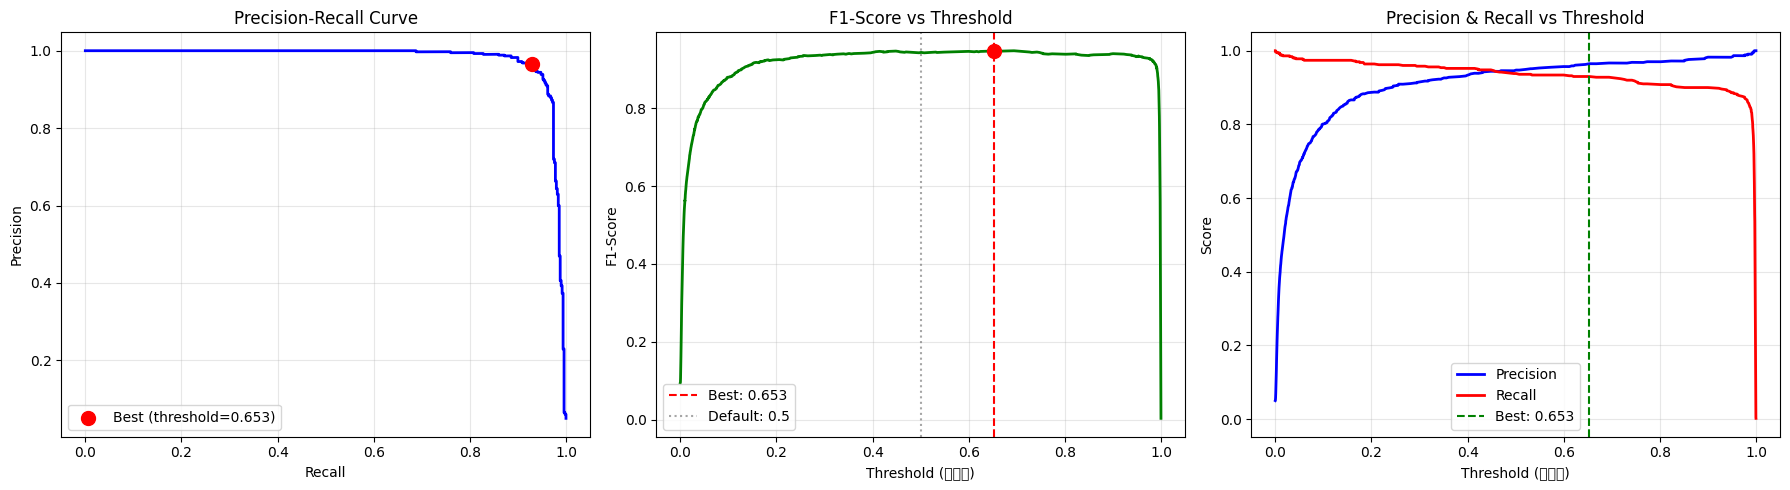


임계값 비교 | Threshold Comparison
임계값 | Threshold           F1-Score       
----------------------------------------
기본 (0.5)                  0.9427         
최적 (0.653)                0.9470         
----------------------------------------
개선율 (Improvement): 0.46%

[최적 임계값 적용 후 Classification Report]
[Classification Report with Optimal Threshold]
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00      9500
 Anomaly (1)       0.96      0.93      0.95       500

    accuracy                           0.99     10000
   macro avg       0.98      0.96      0.97     10000
weighted avg       0.99      0.99      0.99     10000



In [14]:
# A9. 임계값 최적화
# A9. Threshold optimization

# 예측 확률 얻기 (SMOTE 모델 사용) | Get prediction probabilities (using SMOTE model)
y_val_proba = smote_model.predict_proba(X_val)[:, 1]

# Precision-Recall Curve 계산 | Calculate Precision-Recall Curve
precision_arr, recall_arr, thresholds = precision_recall_curve(y_val_cls, y_val_proba)

# F1-Score 계산 (각 임계값에 대해) | Calculate F1-Score (for each threshold)
# F1 = 2 * (precision * recall) / (precision + recall)
# precision_arr, recall_arr는 thresholds보다 1개 더 많음
# precision_arr, recall_arr have one more element than thresholds
f1_scores = 2 * (precision_arr[:-1] * recall_arr[:-1]) / (precision_arr[:-1] + recall_arr[:-1] + 1e-10)

# 최적 임계값 찾기 | Find optimal threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_precision = precision_arr[best_idx]
best_recall = recall_arr[best_idx]

print("=" * 60)
print("최적 임계값 탐색 | Optimal Threshold Search")
print("=" * 60)
print(f"\n기본 임계값 (Default threshold): 0.5")
print(f"최적 임계값 (Optimal threshold): {best_threshold:.4f}")
print(f"\n최적 임계값에서의 성능 | Performance at Optimal Threshold:")
print(f"  - F1-Score: {best_f1:.4f}")
print(f"  - Precision: {best_precision:.4f}")
print(f"  - Recall: {best_recall:.4f}")

# 시각화 | Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Precision-Recall Curve
axes[0].plot(recall_arr, precision_arr, 'b-', linewidth=2)
axes[0].scatter([best_recall], [best_precision], color='red', s=100, zorder=5, 
                label=f'Best (threshold={best_threshold:.3f})')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. F1-Score vs Threshold
axes[1].plot(thresholds, f1_scores, 'g-', linewidth=2)
axes[1].axvline(x=best_threshold, color='red', linestyle='--', label=f'Best: {best_threshold:.3f}')
axes[1].axvline(x=0.5, color='gray', linestyle=':', alpha=0.7, label='Default: 0.5')
axes[1].scatter([best_threshold], [best_f1], color='red', s=100, zorder=5)
axes[1].set_xlabel('Threshold (임계값)')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score vs Threshold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Precision & Recall vs Threshold
axes[2].plot(thresholds, precision_arr[:-1], 'b-', linewidth=2, label='Precision')
axes[2].plot(thresholds, recall_arr[:-1], 'r-', linewidth=2, label='Recall')
axes[2].axvline(x=best_threshold, color='green', linestyle='--', label=f'Best: {best_threshold:.3f}')
axes[2].set_xlabel('Threshold (임계값)')
axes[2].set_ylabel('Score')
axes[2].set_title('Precision & Recall vs Threshold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 최적 임계값 적용 | Apply optimal threshold
y_pred_optimized = (y_val_proba >= best_threshold).astype(int)

# 기본 임계값(0.5)과 최적 임계값 비교 | Compare default threshold (0.5) with optimal threshold
y_pred_default = (y_val_proba >= 0.5).astype(int)

f1_default = f1_score(y_val_cls, y_pred_default)
f1_optimized = f1_score(y_val_cls, y_pred_optimized)

print("\n" + "=" * 60)
print("임계값 비교 | Threshold Comparison")
print("=" * 60)
print(f"{'임계값 | Threshold':<25} {'F1-Score':<15}")
print("-" * 40)
print(f"{'기본 (0.5)':<25} {f1_default:<15.4f}")
print(f"{'최적 (' + f'{best_threshold:.3f}' + ')':<25} {f1_optimized:<15.4f}")
print("-" * 40)
print(f"개선율 (Improvement): {((f1_optimized - f1_default) / f1_default * 100):.2f}%")

# 최적 임계값 적용 후 Classification Report | Classification Report with optimal threshold
print("\n[최적 임계값 적용 후 Classification Report]")
print("[Classification Report with Optimal Threshold]")
print(classification_report(y_val_cls, y_pred_optimized, target_names=['Normal (0)', 'Anomaly (1)']))

---
### Q10. Autoencoder를 사용한 이상 탐지 | Anomaly Detection with Autoencoder

딥러닝 기반 이상 탐지 방법으로 **Autoencoder**를 구현하세요.
- **핵심 아이디어**: 정상 데이터로만 Autoencoder를 학습시키면, 이상 데이터는 재구성 오차(reconstruction error)가 높아집니다.
- 조건:
  - 정상 데이터(anomaly=0)로만 학습
  - Encoder: Input → 32 → 16 → 8 (latent)
  - Decoder: 8 → 16 → 32 → Output
  - 활성화 함수: ReLU
  - 손실 함수: MSE
  - 옵티마이저: Adam

In [15]:
# A10. Autoencoder 정의
# A10. Define Autoencoder

class Autoencoder(nn.Module):
    """
    이상 탐지를 위한 Autoencoder 모델입니다.
    Autoencoder model for anomaly detection.
    
    핵심 아이디어 | Key Idea:
    - 정상 데이터로만 학습하면 이상 데이터는 재구성 오차가 높아집니다.
    - When trained only on normal data, anomalies will have high reconstruction error.
    
    아키텍처 | Architecture:
    - Encoder: Input → 32 → 16 → 8 (latent)
    - Decoder: 8 → 16 → 32 → Output
    """
    
    def __init__(self, input_dim: int):
        """
        Args:
            input_dim: 입력 특성 차원 | Input feature dimension
        """
        super(Autoencoder, self).__init__()
        
        # Encoder: 입력을 저차원 잠재 공간으로 압축
        # Encoder: Compress input to low-dimensional latent space
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),   # Input → 32
            nn.ReLU(),
            nn.Linear(32, 16),          # 32 → 16
            nn.ReLU(),
            nn.Linear(16, 8)            # 16 → 8 (latent)
        )
        
        # Decoder: 잠재 공간에서 원본 차원으로 복원
        # Decoder: Reconstruct from latent space to original dimension
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),           # 8 → 16
            nn.ReLU(),
            nn.Linear(16, 32),          # 16 → 32
            nn.ReLU(),
            nn.Linear(32, input_dim)    # 32 → Output
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        순전파 함수입니다.
        Forward pass function.
        
        Args:
            x: 입력 텐서 | Input tensor
        
        Returns:
            재구성된 출력 텐서 | Reconstructed output tensor
        """
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_reconstruction_error(self, x: torch.Tensor) -> torch.Tensor:
        """
        재구성 오차를 계산합니다.
        Calculate reconstruction error.
        
        Args:
            x: 입력 텐서 | Input tensor
        
        Returns:
            각 샘플의 재구성 오차 (MSE) | Reconstruction error (MSE) for each sample
        """
        reconstructed = self.forward(x)
        # 각 샘플별 MSE 계산 | Calculate MSE for each sample
        error = torch.mean((x - reconstructed) ** 2, dim=1)
        return error

print("✅ Autoencoder 클래스 정의 완료! | Autoencoder class defined!")
print("\n[모델 아키텍처 | Model Architecture]")
print("Encoder: Input → 32 (ReLU) → 16 (ReLU) → 8 (latent)")
print("Decoder: 8 → 16 (ReLU) → 32 (ReLU) → Output")

✅ Autoencoder 클래스 정의 완료! | Autoencoder class defined!

[모델 아키텍처 | Model Architecture]
Encoder: Input → 32 (ReLU) → 16 (ReLU) → 8 (latent)
Decoder: 8 → 16 (ReLU) → 32 (ReLU) → Output


Autoencoder 학습 데이터 | Autoencoder Training Data
정상 데이터로만 학습 | Training only on normal data
학습 데이터 크기: (38000, 23)
검증 데이터 크기: (10000, 23)

학습 설정 | Training Settings:
  - Epochs: 50
  - Batch size: 64
  - Learning rate: 0.001
  - Device: cuda

Autoencoder 학습 시작 | Starting Autoencoder Training
Epoch [ 10/50] - Loss: 0.299948
Epoch [ 20/50] - Loss: 0.288669
Epoch [ 30/50] - Loss: 0.270671
Epoch [ 40/50] - Loss: 0.256819
Epoch [ 50/50] - Loss: 0.247725
✅ Autoencoder 학습 완료! | Autoencoder training completed!


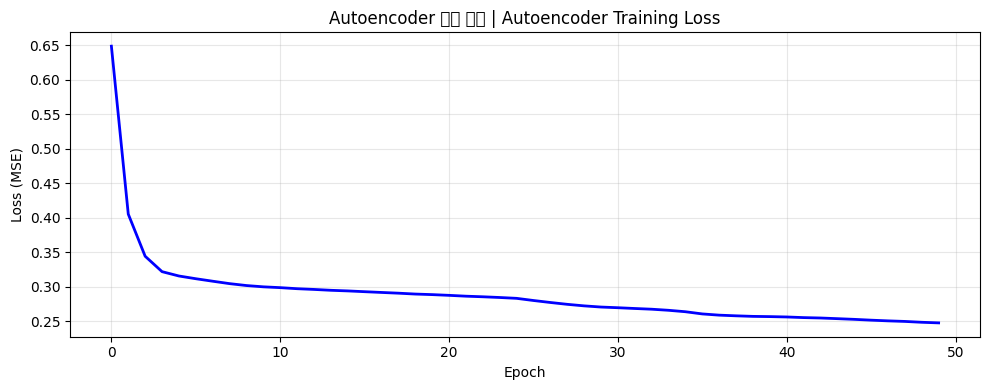


재구성 오차 기반 이상 탐지 | Reconstruction Error-based Anomaly Detection

재구성 오차 임계값 (95th percentile): 0.507690

Autoencoder F1-Score: 0.5092


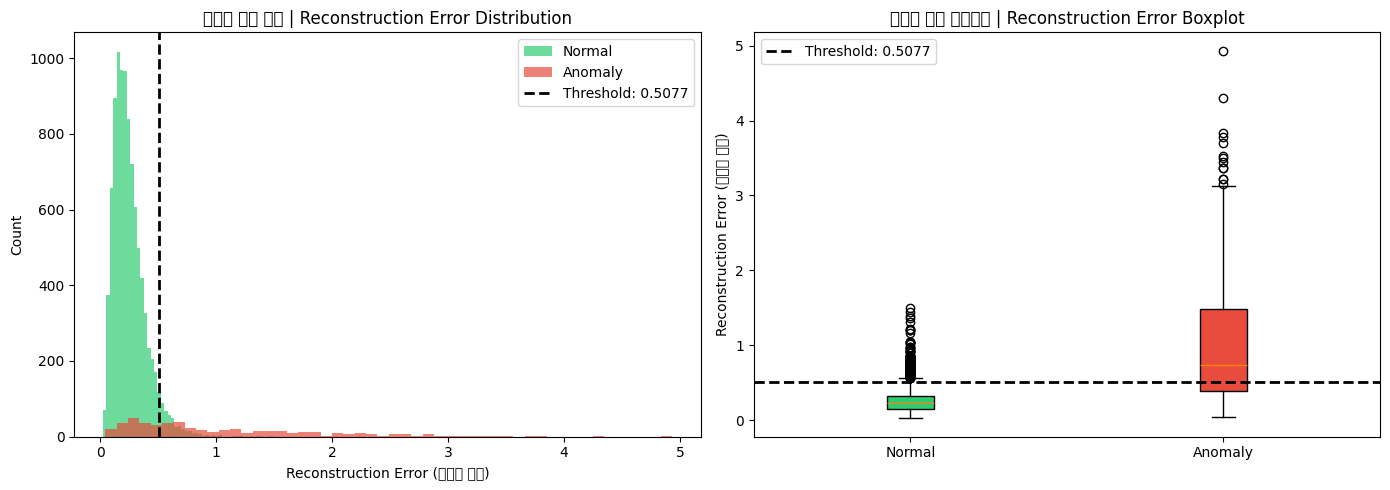


[Autoencoder 성능 요약 | Autoencoder Performance Summary]
  - F1-Score: 0.5092
  - 정상 평균 오차: 0.250177
  - 이상 평균 오차: 1.034995
  - 오차 비율 (이상/정상): 4.14x


In [16]:
# A10-2. Autoencoder 학습 및 이상 탐지
# A10-2. Train Autoencoder and detect anomalies

# 데이터 전처리: 정규화 | Data preprocessing: Normalization
scaler = StandardScaler()

# 인덱스 정렬을 위해 reset_index 사용 | Use reset_index for index alignment
X_train_reset = X_train.reset_index(drop=True)
y_train_cls_reset = y_train_cls.reset_index(drop=True)
X_val_reset = X_val.reset_index(drop=True)
y_val_cls_reset = y_val_cls.reset_index(drop=True)

# 정상 데이터만 추출하여 학습 | Extract only normal data for training
normal_mask = y_train_cls_reset == 0
X_train_normal = X_train_reset[normal_mask]
X_train_scaled = scaler.fit_transform(X_train_normal)
X_val_scaled = scaler.transform(X_val_reset)

print("=" * 60)
print("Autoencoder 학습 데이터 | Autoencoder Training Data")
print("=" * 60)
print(f"정상 데이터로만 학습 | Training only on normal data")
print(f"학습 데이터 크기: {X_train_scaled.shape}")
print(f"검증 데이터 크기: {X_val_scaled.shape}")

# PyTorch 텐서로 변환 | Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)

# DataLoader 생성 | Create DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # 입력 = 출력 (재구성)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 모델 초기화 | Initialize model
input_dim = X_train_scaled.shape[1]
autoencoder = Autoencoder(input_dim).to(device)

# 손실 함수 및 옵티마이저 | Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# 학습 설정 | Training settings
EPOCHS = 50
print(f"\n학습 설정 | Training Settings:")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch size: 64")
print(f"  - Learning rate: 0.001")
print(f"  - Device: {device}")

# 학습 | Training
print("\n" + "=" * 60)
print("Autoencoder 학습 시작 | Starting Autoencoder Training")
print("=" * 60)

train_losses = []
for epoch in range(EPOCHS):
    autoencoder.train()
    epoch_loss = 0.0
    
    for batch_x, _ in train_loader:
        # 순전파 | Forward pass
        reconstructed = autoencoder(batch_x)
        loss = criterion(reconstructed, batch_x)
        
        # 역전파 | Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1:3d}/{EPOCHS}] - Loss: {avg_loss:.6f}")

print("✅ Autoencoder 학습 완료! | Autoencoder training completed!")

# 학습 손실 시각화 | Visualize training loss
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train_losses, 'b-', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Autoencoder 학습 손실 | Autoencoder Training Loss')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 이상 탐지: 재구성 오차 계산 | Anomaly detection: Calculate reconstruction error
print("\n" + "=" * 60)
print("재구성 오차 기반 이상 탐지 | Reconstruction Error-based Anomaly Detection")
print("=" * 60)

autoencoder.eval()
with torch.no_grad():
    # 검증 데이터의 재구성 오차 계산 | Calculate reconstruction error for validation data
    val_reconstructed = autoencoder(X_val_tensor)
    reconstruction_errors = torch.mean((X_val_tensor - val_reconstructed) ** 2, dim=1).cpu().numpy()

# 정상 데이터의 재구성 오차로 임계값 설정 (95번째 백분위수)
# Set threshold using reconstruction error of normal data (95th percentile)
# y_val_cls_reset을 numpy 배열로 변환 | Convert y_val_cls_reset to numpy array
y_val_cls_np = y_val_cls_reset.values
normal_errors = reconstruction_errors[y_val_cls_np == 0]
anomaly_errors = reconstruction_errors[y_val_cls_np == 1]

ae_threshold = np.percentile(normal_errors, 95)
print(f"\n재구성 오차 임계값 (95th percentile): {ae_threshold:.6f}")

# 임계값 기반 예측 | Threshold-based prediction
y_pred_ae = (reconstruction_errors > ae_threshold).astype(int)

# 성능 평가 | Performance evaluation
f1_ae = f1_score(y_val_cls_np, y_pred_ae)
print(f"\nAutoencoder F1-Score: {f1_ae:.4f}")

# 재구성 오차 분포 시각화 | Visualize reconstruction error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램 | Histogram
axes[0].hist(normal_errors, bins=50, alpha=0.7, label='Normal', color='#2ecc71')
axes[0].hist(anomaly_errors, bins=50, alpha=0.7, label='Anomaly', color='#e74c3c')
axes[0].axvline(x=ae_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {ae_threshold:.4f}')
axes[0].set_xlabel('Reconstruction Error (재구성 오차)')
axes[0].set_ylabel('Count')
axes[0].set_title('재구성 오차 분포 | Reconstruction Error Distribution')
axes[0].legend()

# 박스플롯 | Boxplot
error_data = [normal_errors, anomaly_errors]
bp = axes[1].boxplot(error_data, labels=['Normal', 'Anomaly'], patch_artist=True)
bp['boxes'][0].set_facecolor('#2ecc71')
bp['boxes'][1].set_facecolor('#e74c3c')
axes[1].axhline(y=ae_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {ae_threshold:.4f}')
axes[1].set_ylabel('Reconstruction Error (재구성 오차)')
axes[1].set_title('재구성 오차 박스플롯 | Reconstruction Error Boxplot')
axes[1].legend()

plt.tight_layout()
plt.show()

# Autoencoder 예측을 확률로 변환 (앙상블용) | Convert Autoencoder predictions to probabilities (for ensemble)
# Min-Max 정규화로 0~1 범위로 변환 | Normalize to 0~1 range using Min-Max
error_min = reconstruction_errors.min()
error_max = reconstruction_errors.max()
y_pred_proba_ae = (reconstruction_errors - error_min) / (error_max - error_min + 1e-10)

print("\n[Autoencoder 성능 요약 | Autoencoder Performance Summary]")
print(f"  - F1-Score: {f1_ae:.4f}")
print(f"  - 정상 평균 오차: {normal_errors.mean():.6f}")
print(f"  - 이상 평균 오차: {anomaly_errors.mean():.6f}")
print(f"  - 오차 비율 (이상/정상): {anomaly_errors.mean() / normal_errors.mean():.2f}x")

---
### Q11. 앙상블 및 최종 평가 | Ensemble and Final Evaluation

지금까지 학습한 여러 모델의 예측을 앙상블하여 최종 성능을 측정하세요.
- 앙상블 방법: Soft Voting (확률 평균)
- 사용 모델: Q7 모델, Q8 모델 (선택적으로 Q10의 Autoencoder 추가)
- 최종 F1-Score, AUC-ROC, Classification Report 출력

앙상블 모델 구성 | Ensemble Model Configuration

사용 모델 | Models Used:
  1. Baseline Model (Q7): XGBoost with class weights
  2. SMOTE Model (Q8): XGBoost with SMOTE

앙상블 방법 | Ensemble Method: Soft Voting (확률 평균)

앙상블 모델 성능 | Ensemble Model Performance

F1-Score: 0.9492
AUC-ROC: 0.9955

[Classification Report]
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00      9500
 Anomaly (1)       0.96      0.93      0.95       500

    accuracy                           0.99     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.99      0.99      0.99     10000


전체 모델 성능 비교 | All Model Performance Comparison

모델 | Model                          F1-Score     AUC-ROC     
------------------------------------------------------------
1. Baseline (Class Weight)          0.9279       0.9950      
2. SMOTE                            0.9427       0.9953      
3. Autoencoder                      0.5092       N/A         
4. Ensemble

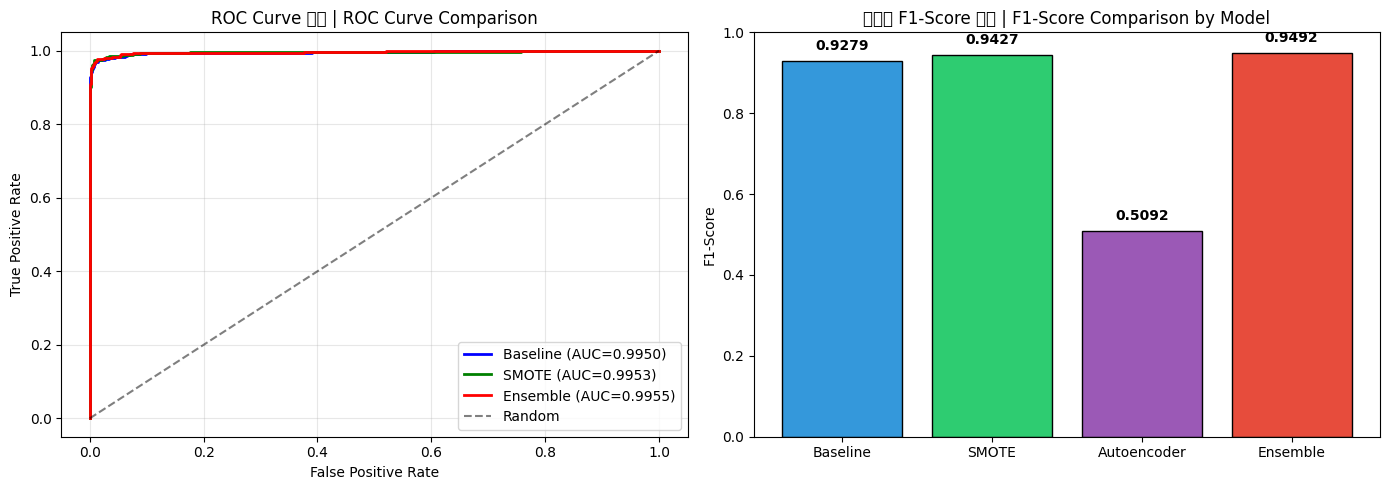

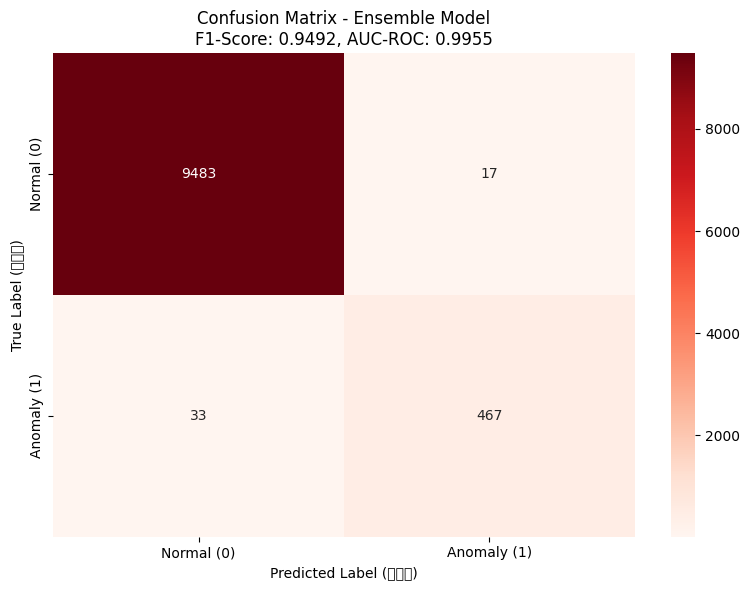


✅ 앙상블 모델 평가 완료! | Ensemble model evaluation completed!
✅ 최종 분류 F1-Score: 0.9492
✅ 최종 분류 AUC-ROC: 0.9955


In [17]:
# A11. 앙상블 및 최종 평가
# A11. Ensemble and final evaluation

print("=" * 60)
print("앙상블 모델 구성 | Ensemble Model Configuration")
print("=" * 60)
print("\n사용 모델 | Models Used:")
print("  1. Baseline Model (Q7): XGBoost with class weights")
print("  2. SMOTE Model (Q8): XGBoost with SMOTE")
print("\n앙상블 방법 | Ensemble Method: Soft Voting (확률 평균)")

# 각 모델의 예측 확률 | Prediction probabilities from each model
# baseline_model: Q7에서 학습한 모델 | Model trained in Q7
# smote_model: Q8에서 학습한 모델 | Model trained in Q8

# Soft Voting: 확률 평균 | Soft Voting: Average probabilities
y_ensemble_proba = (y_pred_proba_baseline + y_pred_proba_smote) / 2

# 최적 임계값 적용하여 최종 예측 | Apply optimal threshold for final prediction
y_pred_ensemble = (y_ensemble_proba >= best_threshold).astype(int)

# 앙상블 성능 평가 | Ensemble performance evaluation
f1_ensemble = f1_score(y_val_cls, y_pred_ensemble)
auc_ensemble = roc_auc_score(y_val_cls, y_ensemble_proba)

print("\n" + "=" * 60)
print("앙상블 모델 성능 | Ensemble Model Performance")
print("=" * 60)
print(f"\nF1-Score: {f1_ensemble:.4f}")
print(f"AUC-ROC: {auc_ensemble:.4f}")

print("\n[Classification Report]")
print(classification_report(y_val_cls, y_pred_ensemble, target_names=['Normal (0)', 'Anomaly (1)']))

# 모든 모델 성능 비교 | Compare all model performances
print("\n" + "=" * 60)
print("전체 모델 성능 비교 | All Model Performance Comparison")
print("=" * 60)
print(f"\n{'모델 | Model':<35} {'F1-Score':<12} {'AUC-ROC':<12}")
print("-" * 60)
print(f"{'1. Baseline (Class Weight)':<35} {f1_baseline:<12.4f} {auc_baseline:<12.4f}")
print(f"{'2. SMOTE':<35} {f1_smote:<12.4f} {auc_smote:<12.4f}")
print(f"{'3. Autoencoder':<35} {f1_ae:<12.4f} {'N/A':<12}")
print(f"{'4. Ensemble (Baseline + SMOTE)':<35} {f1_ensemble:<12.4f} {auc_ensemble:<12.4f}")
print("-" * 60)

# 최고 성능 모델 표시 | Indicate best performing model
models_f1 = {
    'Baseline': f1_baseline,
    'SMOTE': f1_smote,
    'Autoencoder': f1_ae,
    'Ensemble': f1_ensemble
}
best_model = max(models_f1, key=models_f1.get)
print(f"\n🏆 최고 F1-Score 모델 | Best F1-Score Model: {best_model} ({models_f1[best_model]:.4f})")

# ROC Curve 비교 시각화 | Visualize ROC Curve comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr_baseline, tpr_baseline, _ = roc_curve(y_val_cls, y_pred_proba_baseline)
fpr_smote, tpr_smote, _ = roc_curve(y_val_cls, y_pred_proba_smote)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_val_cls, y_ensemble_proba)

axes[0].plot(fpr_baseline, tpr_baseline, 'b-', label=f'Baseline (AUC={auc_baseline:.4f})', linewidth=2)
axes[0].plot(fpr_smote, tpr_smote, 'g-', label=f'SMOTE (AUC={auc_smote:.4f})', linewidth=2)
axes[0].plot(fpr_ensemble, tpr_ensemble, 'r-', label=f'Ensemble (AUC={auc_ensemble:.4f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve 비교 | ROC Curve Comparison')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# F1-Score 비교 막대 그래프 | F1-Score comparison bar chart
model_names = list(models_f1.keys())
f1_values = list(models_f1.values())
colors = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c']
bars = axes[1].bar(model_names, f1_values, color=colors, edgecolor='black')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('모델별 F1-Score 비교 | F1-Score Comparison by Model')
axes[1].set_ylim(0, 1)

# 막대 위에 값 표시 | Display values on bars
for bar, val in zip(bars, f1_values):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                 f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Confusion Matrix 시각화 | Visualize Confusion Matrix
cm_ensemble = confusion_matrix(y_val_cls, y_pred_ensemble)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Reds', ax=ax,
            xticklabels=['Normal (0)', 'Anomaly (1)'],
            yticklabels=['Normal (0)', 'Anomaly (1)'])
ax.set_xlabel('Predicted Label (예측값)')
ax.set_ylabel('True Label (실제값)')
ax.set_title(f'Confusion Matrix - Ensemble Model\nF1-Score: {f1_ensemble:.4f}, AUC-ROC: {auc_ensemble:.4f}')
plt.tight_layout()
plt.show()

# 최종 분류 결과 저장 | Save final classification results
final_cls_f1 = f1_ensemble
final_cls_auc = auc_ensemble
print(f"\n✅ 앙상블 모델 평가 완료! | Ensemble model evaluation completed!")
print(f"✅ 최종 분류 F1-Score: {final_cls_f1:.4f}")
print(f"✅ 최종 분류 AUC-ROC: {final_cls_auc:.4f}")

---
### Q12. 회귀 모델 - 건강 점수 예측 | Regression Model - Health Score Prediction

두 번째 태스크로 `health_score`를 예측하는 회귀 모델을 학습하세요.
- LightGBM Regressor 사용
- Optuna를 사용하여 하이퍼파라미터 튜닝 (n_trials=20)
- 검증 데이터에 대한 RMSE와 R² Score 출력

회귀 모델: 건강 점수 예측 | Regression Model: Health Score Prediction

학습 데이터: 40,000개
검증 데이터: 10,000개
타겟 범위: 20.00 ~ 100.00
타겟 평균: 87.51

Optuna 하이퍼파라미터 최적화 | Optuna Hyperparameter Optimization

최적화 시작... | Starting optimization...


  0%|          | 0/20 [00:00<?, ?it/s]


최적 하이퍼파라미터 | Best Hyperparameters
  n_estimators: 110
  max_depth: 6
  learning_rate: 0.048425
  num_leaves: 100
  min_child_samples: 38
  subsample: 0.741849
  colsample_bytree: 0.980369

최적 RMSE (Best RMSE): 6.9760

최종 회귀 모델 학습 | Training Final Regression Model

[최종 회귀 모델 성능 | Final Regression Model Performance]
  - RMSE: 6.9760
  - R² Score: 0.6891


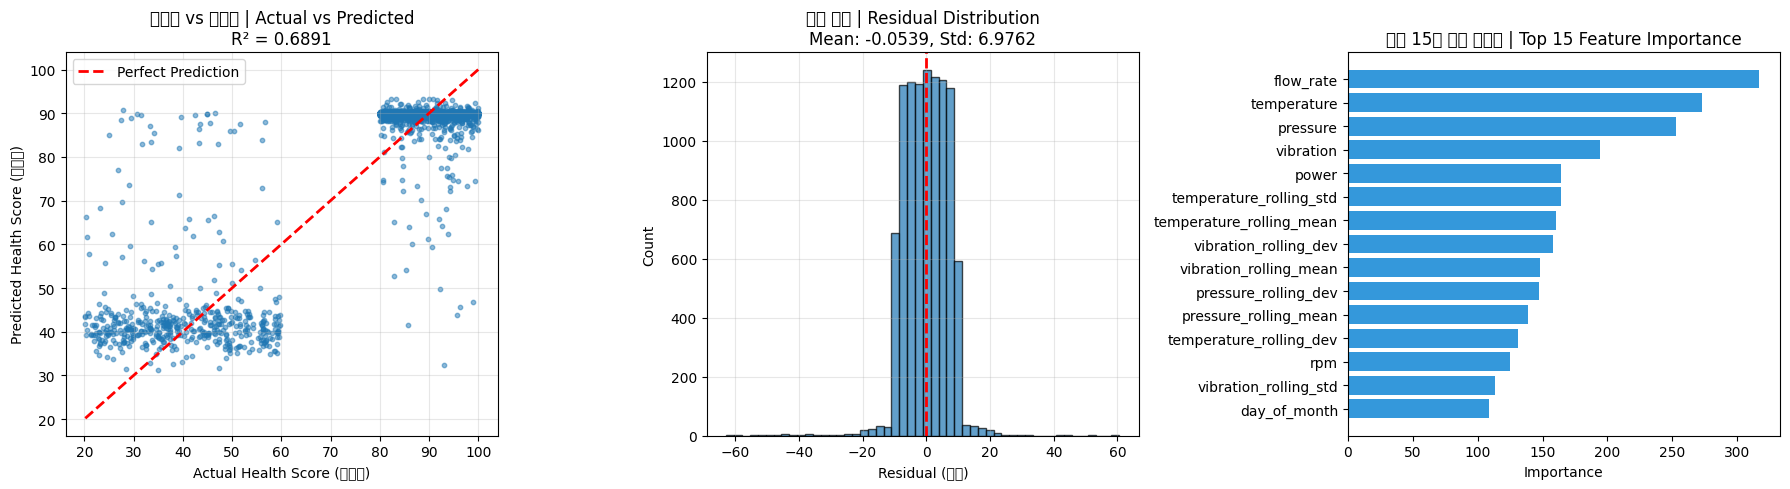


✅ 회귀 모델 학습 완료! | Regression model training completed!
✅ 최종 RMSE: 6.9760
✅ 최종 R²: 0.6891


In [18]:
# A12. 회귀 모델 학습
# A12. Train regression model

# 회귀 타겟 준비 | Prepare regression target
y_train_reg = train.loc[X_train.index, 'health_score']
y_val_reg = train.loc[X_val.index, 'health_score']

print("=" * 60)
print("회귀 모델: 건강 점수 예측 | Regression Model: Health Score Prediction")
print("=" * 60)
print(f"\n학습 데이터: {len(y_train_reg):,}개")
print(f"검증 데이터: {len(y_val_reg):,}개")
print(f"타겟 범위: {y_train_reg.min():.2f} ~ {y_train_reg.max():.2f}")
print(f"타겟 평균: {y_train_reg.mean():.2f}")

# Optuna objective 함수 정의 | Define Optuna objective function
def objective_reg(trial: optuna.Trial) -> float:
    """
    Optuna 하이퍼파라미터 최적화를 위한 목적 함수입니다.
    Objective function for Optuna hyperparameter optimization.
    
    Args:
        trial: Optuna trial 객체 | Optuna trial object
    
    Returns:
        검증 데이터에 대한 RMSE | RMSE on validation data
    """
    # 하이퍼파라미터 탐색 범위 정의 | Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': RANDOM_SEED,
        'verbose': -1
    }
    
    # 모델 학습 | Train model
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train_reg)
    
    # 검증 데이터 예측 | Predict on validation data
    y_pred = model.predict(X_val)
    
    # RMSE 계산 | Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred))
    
    return rmse

# 스터디 생성 및 최적화 | Create study and optimize
print("\n" + "=" * 60)
print("Optuna 하이퍼파라미터 최적화 | Optuna Hyperparameter Optimization")
print("=" * 60)
print("\n최적화 시작... | Starting optimization...")

study_reg = optuna.create_study(direction='minimize')  # RMSE 최소화 | Minimize RMSE
study_reg.optimize(objective_reg, n_trials=20, show_progress_bar=True)

# 최적 하이퍼파라미터 출력 | Print best hyperparameters
print("\n" + "=" * 60)
print("최적 하이퍼파라미터 | Best Hyperparameters")
print("=" * 60)
for key, value in study_reg.best_params.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.6f}")
    else:
        print(f"  {key}: {value}")
print(f"\n최적 RMSE (Best RMSE): {study_reg.best_value:.4f}")

# 최적 하이퍼파라미터로 최종 모델 학습 | Train final model with best hyperparameters
best_params = study_reg.best_params
best_params['random_state'] = RANDOM_SEED
best_params['verbose'] = -1

print("\n" + "=" * 60)
print("최종 회귀 모델 학습 | Training Final Regression Model")
print("=" * 60)

reg_model = LGBMRegressor(**best_params)
reg_model.fit(X_train, y_train_reg)

# 검증 데이터 예측 | Predict on validation data
y_pred_reg = reg_model.predict(X_val)

# 성능 평가 | Performance evaluation
final_rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred_reg))
final_r2 = r2_score(y_val_reg, y_pred_reg)

print(f"\n[최종 회귀 모델 성능 | Final Regression Model Performance]")
print(f"  - RMSE: {final_rmse:.4f}")
print(f"  - R² Score: {final_r2:.4f}")

# 예측값 분포 시각화 | Visualize prediction distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. 실제값 vs 예측값 산점도 | Scatter plot: Actual vs Predicted
axes[0].scatter(y_val_reg, y_pred_reg, alpha=0.5, s=10)
axes[0].plot([y_val_reg.min(), y_val_reg.max()], [y_val_reg.min(), y_val_reg.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Health Score (실제값)')
axes[0].set_ylabel('Predicted Health Score (예측값)')
axes[0].set_title(f'실제값 vs 예측값 | Actual vs Predicted\nR² = {final_r2:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 잔차 분포 | Residual distribution
residuals = y_val_reg - y_pred_reg
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residual (잔차)')
axes[1].set_ylabel('Count')
axes[1].set_title(f'잔차 분포 | Residual Distribution\nMean: {residuals.mean():.4f}, Std: {residuals.std():.4f}')
axes[1].grid(True, alpha=0.3)

# 3. Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[2].barh(feature_importance['feature'], feature_importance['importance'], color='#3498db')
axes[2].set_xlabel('Importance')
axes[2].set_title('상위 15개 특성 중요도 | Top 15 Feature Importance')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

# 최종 회귀 결과 저장 | Save final regression results
final_reg_rmse = final_rmse
final_reg_r2 = final_r2

print(f"\n✅ 회귀 모델 학습 완료! | Regression model training completed!")
print(f"✅ 최종 RMSE: {final_reg_rmse:.4f}")
print(f"✅ 최종 R²: {final_reg_r2:.4f}")

---
### Q13. Test 데이터 예측 및 제출 파일 생성 | Predict Test Data and Create Submission

- 학습한 분류 모델로 test 데이터의 `anomaly`를 예측하세요
- 학습한 회귀 모델로 test 데이터의 `health_score`를 예측하세요
- 예측값을 sample_submission.csv에 채워 제출 파일을 생성하세요

Test 데이터 예측 | Test Data Prediction

Test 데이터 크기: (10000, 23)
사용 특성 수: 23개
Test 데이터 결측치: 0개

----------------------------------------
분류 예측 (앙상블) | Classification Prediction (Ensemble)
----------------------------------------
예측 완료! | Prediction completed!
이상(1) 예측 개수: 20개 (0.20%)
정상(0) 예측 개수: 9,980개 (99.80%)

----------------------------------------
회귀 예측 | Regression Prediction
----------------------------------------
예측 완료! | Prediction completed!
Health Score 범위: 39.99 ~ 93.41
Health Score 평균: 89.79
클리핑 후 범위: 39.99 ~ 93.41

제출 파일 생성 | Creating Submission File

✅ 제출 파일 생성 완료! | Submission file created!
✅ 파일명: submission_2025.csv

----------------------------------------
제출 파일 미리보기 | Submission File Preview
----------------------------------------
   id  anomaly  health_score
0   0        0     89.923255
1   1        0     90.051873
2   2        0     89.972115
3   3        0     90.046475
4   4        0     89.997191
5   5        0     89.987663
6   6        0     89.960143
7   7    

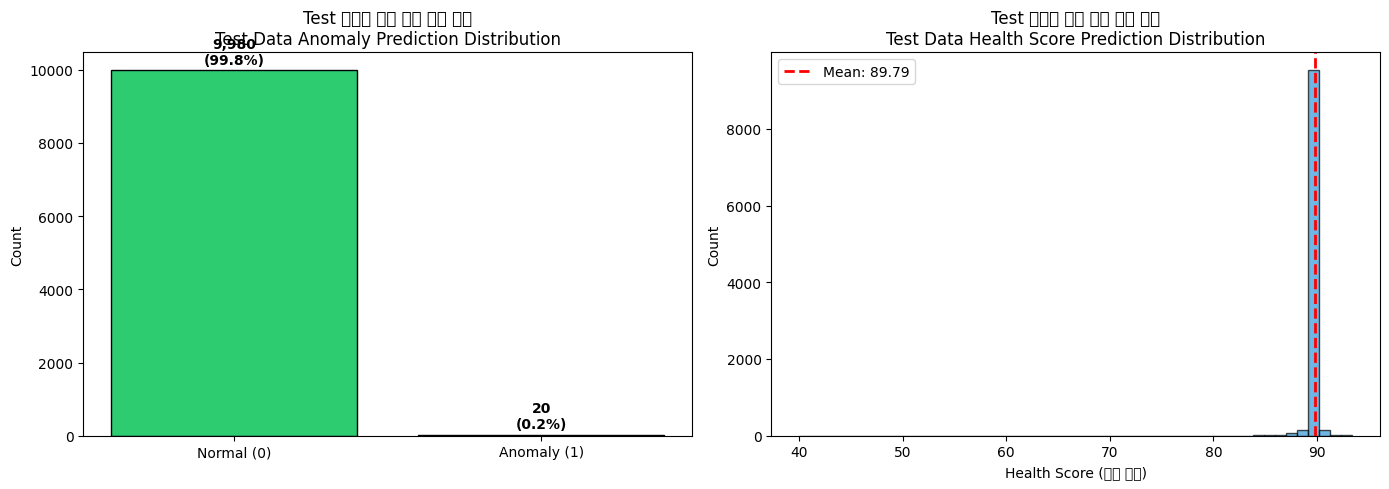


🎉 모든 예측 및 제출 파일 생성 완료! | All predictions and submission file created!
🎉 submission_2025.csv 파일을 제출하세요! | Submit the submission_2025.csv file!


In [19]:
# A13. Test 데이터 예측 및 제출 파일 생성
# A13. Predict test data and create submission

print("=" * 60)
print("Test 데이터 예측 | Test Data Prediction")
print("=" * 60)

# Test 데이터 전처리 (train과 동일하게) | Preprocess test data (same as train)
# 주의: test 데이터는 이미 Q2, Q4, Q5에서 전처리 완료
# Note: test data already preprocessed in Q2, Q4, Q5

# Test 데이터에 존재하는 특성 컬럼만 사용 | Use only feature columns that exist in test data
available_feature_cols = [col for col in feature_cols if col in test.columns]

# 누락된 컬럼 확인 | Check for missing columns
missing_cols = set(feature_cols) - set(available_feature_cols)
if missing_cols:
    print(f"⚠️ 경고: Test 데이터에 없는 컬럼: {missing_cols}")
    print("   Warning: Columns not in test data")

# Test 데이터의 특성 추출 | Extract features from test data
X_test = test[available_feature_cols]
print(f"\nTest 데이터 크기: {X_test.shape}")
print(f"사용 특성 수: {len(available_feature_cols)}개")

# 결측치 확인 | Check for missing values
missing_count = X_test.isnull().sum().sum()
print(f"Test 데이터 결측치: {missing_count}개")

if missing_count > 0:
    print("⚠️ 결측치 발견! 추가 처리 진행...")
    X_test = X_test.bfill().ffill().fillna(0)
    print(f"처리 후 결측치: {X_test.isnull().sum().sum()}개")

# 분류 예측 (앙상블 모델) | Classification prediction (Ensemble model)
print("\n" + "-" * 40)
print("분류 예측 (앙상블) | Classification Prediction (Ensemble)")
print("-" * 40)

# 각 모델의 예측 확률 | Prediction probabilities from each model
test_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]
test_proba_smote = smote_model.predict_proba(X_test)[:, 1]

# 앙상블 확률 (평균) | Ensemble probability (average)
test_proba_ensemble = (test_proba_baseline + test_proba_smote) / 2

# 최적 임계값 적용 | Apply optimal threshold
test_pred_anomaly = (test_proba_ensemble >= best_threshold).astype(int)

print(f"예측 완료! | Prediction completed!")
print(f"이상(1) 예측 개수: {test_pred_anomaly.sum():,}개 ({test_pred_anomaly.mean() * 100:.2f}%)")
print(f"정상(0) 예측 개수: {(test_pred_anomaly == 0).sum():,}개 ({(test_pred_anomaly == 0).mean() * 100:.2f}%)")

# 회귀 예측 | Regression prediction
print("\n" + "-" * 40)
print("회귀 예측 | Regression Prediction")
print("-" * 40)

test_pred_health = reg_model.predict(X_test)

# Health score 범위 확인 및 클리핑 | Check health score range and clip
print(f"예측 완료! | Prediction completed!")
print(f"Health Score 범위: {test_pred_health.min():.2f} ~ {test_pred_health.max():.2f}")
print(f"Health Score 평균: {test_pred_health.mean():.2f}")

# 0-100 범위로 클리핑 (필요시) | Clip to 0-100 range (if needed)
test_pred_health = np.clip(test_pred_health, 0, 100)
print(f"클리핑 후 범위: {test_pred_health.min():.2f} ~ {test_pred_health.max():.2f}")

# 제출 파일 생성 | Create submission file
print("\n" + "=" * 60)
print("제출 파일 생성 | Creating Submission File")
print("=" * 60)

submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')
submission['anomaly'] = test_pred_anomaly
submission['health_score'] = test_pred_health

# 제출 파일 저장 | Save submission file
submission.to_csv('submission_2025.csv', index=False)
print("\n✅ 제출 파일 생성 완료! | Submission file created!")
print("✅ 파일명: submission_2025.csv")

# 제출 파일 미리보기 | Preview submission file
print("\n" + "-" * 40)
print("제출 파일 미리보기 | Submission File Preview")
print("-" * 40)
print(submission.head(10))

print("\n" + "-" * 40)
print("제출 파일 통계 | Submission File Statistics")
print("-" * 40)
print(submission.describe())

# 제출 파일 예측 분포 시각화 | Visualize submission prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 이상 탐지 예측 분포 | Anomaly prediction distribution
anomaly_counts = submission['anomaly'].value_counts().sort_index()
colors = ['#2ecc71', '#e74c3c']
count_normal = anomaly_counts.get(0, 0)
count_anomaly = anomaly_counts.get(1, 0)
bars = axes[0].bar(['Normal (0)', 'Anomaly (1)'], [count_normal, count_anomaly], 
                    color=colors, edgecolor='black')
axes[0].set_title('Test 데이터 이상 탐지 예측 분포\nTest Data Anomaly Prediction Distribution')
axes[0].set_ylabel('Count')
for bar, count in zip(bars, [count_normal, count_anomaly]):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100,
                 f'{count:,}\n({count/len(submission)*100:.1f}%)',
                 ha='center', va='bottom', fontweight='bold')

# 건강 점수 예측 분포 | Health score prediction distribution
axes[1].hist(submission['health_score'], bins=50, edgecolor='black', alpha=0.7, color='#3498db')
axes[1].axvline(x=submission['health_score'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {submission["health_score"].mean():.2f}')
axes[1].set_xlabel('Health Score (건강 점수)')
axes[1].set_ylabel('Count')
axes[1].set_title('Test 데이터 건강 점수 예측 분포\nTest Data Health Score Prediction Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n🎉 모든 예측 및 제출 파일 생성 완료! | All predictions and submission file created!")
print("🎉 submission_2025.csv 파일을 제출하세요! | Submit the submission_2025.csv file!")

---
## << 최종 요약 | Final Summary >>

| Task | Metric | Score |
|------|--------|-------|
| 이상 탐지 (Classification) | F1-Score | ??? |
| 이상 탐지 (Classification) | AUC-ROC | ??? |
| 건강 점수 예측 (Regression) | RMSE | ??? |
| 건강 점수 예측 (Regression) | R² | ??? |

In [20]:
# 최종 결과 요약 출력
# Print final results summary

print("=" * 70)
print("                    최종 결과 요약 | Final Results Summary")
print("=" * 70)

print("\n┌" + "─" * 68 + "┐")
print("│" + " " * 20 + "이상 탐지 (Classification)" + " " * 21 + "│")
print("├" + "─" * 68 + "┤")
print(f"│  • 앙상블 F1-Score:        {final_cls_f1:.4f}" + " " * 35 + "│")
print(f"│  • 앙상블 AUC-ROC:         {final_cls_auc:.4f}" + " " * 35 + "│")
print(f"│  • 최적 임계값:            {best_threshold:.4f}" + " " * 35 + "│")
print("└" + "─" * 68 + "┘")

print("\n┌" + "─" * 68 + "┐")
print("│" + " " * 18 + "건강 점수 예측 (Regression)" + " " * 21 + "│")
print("├" + "─" * 68 + "┤")
print(f"│  • RMSE:                   {final_reg_rmse:.4f}" + " " * 35 + "│")
print(f"│  • R² Score:               {final_reg_r2:.4f}" + " " * 35 + "│")
print("└" + "─" * 68 + "┘")

print("\n" + "=" * 70)
print("                      사용된 모델 | Models Used")
print("=" * 70)
print("""
[분류 모델 | Classification Models]
  1. Baseline: XGBoost with class weights (scale_pos_weight)
  2. SMOTE: XGBoost trained on SMOTE-balanced data
  3. Autoencoder: Reconstruction error-based anomaly detection
  4. Ensemble: Soft Voting (Baseline + SMOTE)

[회귀 모델 | Regression Model]
  • LightGBM with Optuna hyperparameter tuning (n_trials=20)
""")

print("=" * 70)
print("                       핵심 기법 | Key Techniques")
print("=" * 70)
print("""
1. 데이터 전처리 | Data Preprocessing:
   - 선형 보간 + ffill/bfill로 결측치 처리
   - Linear interpolation + ffill/bfill for missing values

2. 특성 공학 | Feature Engineering:
   - 시간 기반 특성 (순환 변환: sin/cos)
   - Time-based features (cyclic transformation: sin/cos)
   - 롤링 통계량 (이동 평균, 이동 표준편차)
   - Rolling statistics (rolling mean, rolling std)

3. 클래스 불균형 처리 | Handling Class Imbalance:
   - Class weights (scale_pos_weight)
   - SMOTE oversampling
   - Threshold optimization (Precision-Recall Curve)

4. 앙상블 | Ensemble:
   - Soft Voting (확률 평균)
   - Soft Voting (probability average)

5. 하이퍼파라미터 최적화 | Hyperparameter Optimization:
   - Optuna를 사용한 자동 하이퍼파라미터 튜닝
   - Automated hyperparameter tuning with Optuna
""")

print("=" * 70)
print("                    🎉 분석 완료! | Analysis Complete! 🎉")
print("=" * 70)
print("\n📁 생성된 파일 | Generated File: submission_2025.csv")
print("📊 이 파일을 제출하여 최종 점수를 확인하세요!")
print("📊 Submit this file to check your final score!")

                    최종 결과 요약 | Final Results Summary

┌────────────────────────────────────────────────────────────────────┐
│                    이상 탐지 (Classification)                     │
├────────────────────────────────────────────────────────────────────┤
│  • 앙상블 F1-Score:        0.9492                                   │
│  • 앙상블 AUC-ROC:         0.9955                                   │
│  • 최적 임계값:            0.6530                                   │
└────────────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────────────┐
│                  건강 점수 예측 (Regression)                     │
├────────────────────────────────────────────────────────────────────┤
│  • RMSE:                   6.9760                                   │
│  • R² Score:               0.6891                                   │
└────────────────────────────────────────────────────────────────────┘

                      사용된 모델 | Models Us